In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from glob import glob
import tensorflow as tf
import tensorflow.keras as keras
import keras.backend as K
import tensorflow.keras.layers as L
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, MaxPool2D, Add, Dropout, Concatenate, Conv2DTranspose, Dense, Reshape, Flatten, Softmax, Lambda, UpSampling2D, AveragePooling2D, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D, SeparableConv2D,Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import pandas as pd

2024-06-13 08:25:59.553420: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 08:25:59.553525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 08:25:59.677289: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from sklearn.datasets import make_blobs
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import Callback
from keras.optimizers import SGD
from keras import backend
from math import pi
from math import cos
from math import floor

In [3]:
class ISIC_2016:
    def __init__(self, data_dir, image_size=(256, 256), batch_size=8, mode='train'):
        self.data_dir = data_dir
        self.image_size = image_size
        self.batch_size = batch_size
        self.mode = mode

        # Load CSV files based on the mode
        if self.mode == 'train':
            csv_filename = "/kaggle/input/isic-2016-dataset/train_ISIC_2016.csv"
        elif self.mode == 'val':
            csv_filename = "/kaggle/input/isic-2016-dataset/val_ISIC_2016.csv"
        elif self.mode == 'test':
            csv_filename = "/kaggle/input/isic-2016-dataset/test_ISIC_2016.csv"

        self.csv_path = os.path.join(self.data_dir, csv_filename)
        self.df = pd.read_csv(self.csv_path)
        
        
        if self.mode == 'test':
        # Define image and mask paths
            self.image_path = os.path.join(self.data_dir, "ISBI2016_ISIC_Part1_Test_Data")
            self.mask_path = os.path.join(self.data_dir, "ISBI2016_ISIC_Part1_Test_GroundTruth")
        else:
            self.image_path = os.path.join(self.data_dir, "ISBI2016_ISIC_Part1_Training_Data")
            self.mask_path = os.path.join(self.data_dir, "ISBI2016_ISIC_Part1_Training_GroundTruth")

        # Initialize the current batch index to 0
        self.current_batch_index = 0

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def __iter__(self):
        while self.current_batch_index < len(self.df):
            batch_images = []
            batch_masks = []
            for i in range(self.current_batch_index, min(self.current_batch_index + self.batch_size, len(self.df))):
                image_name = self.df.iloc[i]['Image_Id']
                mask_name = self.df.iloc[i]['Image_Id'][:-4]+'_Segmentation'+'.png'

                image = load_img(os.path.join(self.image_path, image_name), target_size=self.image_size)
                mask = load_img(os.path.join(self.mask_path, mask_name), target_size=self.image_size, color_mode='grayscale')

                image_arr = img_to_array(image) / 255.0
                mask_arr = img_to_array(mask) / 255.0

                batch_images.append(image_arr)
                batch_masks.append(mask_arr)

            batch_images = np.array(batch_images)
            batch_masks = np.array(batch_masks)

            # Update the current batch index for the next iteration
            self.current_batch_index += self.batch_size

            yield batch_images, batch_masks
            
        # Reset the current batch index at the end of one epoch
        self.current_batch_index = 0

In [4]:
train_data_loader = ISIC_2016(data_dir='/kaggle/input/isic-2016-dataset/ISIC_2016_dataset/ISIC_2016_dataset', image_size=(512, 512), batch_size=4, mode='train')
val_data_loader = ISIC_2016(data_dir='/kaggle/input/isic-2016-dataset/ISIC_2016_dataset/ISIC_2016_dataset', image_size=(512, 512), batch_size=4, mode='val')    
test_data_loader = ISIC_2016(data_dir='/kaggle/input/isic-2016-dataset/ISIC_2016_dataset/ISIC_2016_dataset', image_size=(512, 512), batch_size=4, mode='test')
    
train_dataset = tf.data.Dataset.from_generator(lambda: train_data_loader, output_signature=(tf.TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32), tf.TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32)))
val_dataset = tf.data.Dataset.from_generator(lambda: val_data_loader, output_signature=(tf.TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32), tf.TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32)))
test_dataset = tf.data.Dataset.from_generator(lambda: test_data_loader, output_signature=(tf.TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32), tf.TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32)))

In [5]:
def dice_score(y_true, y_pred):
    smooth = K.epsilon()
    y_true_flat = K.flatten(K.cast(y_true, 'float32'))
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    score = (2. * intersection + smooth) / (K.sum(y_true_flat) + K.sum(y_pred_flat) + smooth)
    return score

def iou(y_true, y_pred):
    smooth = K.epsilon()
    y_true_flat = K.flatten(K.cast(y_true, 'float32'))
    y_pred_flat = K.flatten(y_pred)
    intersection = K.sum(y_true_flat * y_pred_flat)
    union = K.sum(y_true_flat) + K.sum(y_pred_flat) - intersection + smooth
    iou = (intersection + smooth) / union
    return iou

def recall(y_true, y_pred):
    smooth = K.epsilon()
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_true_flat = K.flatten(K.cast(y_true, 'float32'))
    y_pred_flat = K.flatten(y_pred_pos)
    tp = K.sum(y_true_flat * y_pred_flat)
    fn = K.sum(y_true_flat * (1 - y_pred_flat))
    recall = (tp + smooth) / (tp + fn + smooth)
    return recall

def precision(y_true, y_pred):
    smooth = K.epsilon()
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_true_flat = K.flatten(K.cast(y_true, 'float32'))
    y_pred_flat = K.flatten(y_pred_pos)
    tp = K.sum(y_true_flat * y_pred_flat)
    fp = K.sum((1 - y_true_flat) * y_pred_flat)
    precision = (tp + smooth) / (tp + fp + smooth)
    return precision

In [6]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_score(y_true, y_pred)
    return loss

def iou_loss(y_true, y_pred):
    loss = 1 - iou(y_true, y_pred)
    return loss
    
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
    y_true = tf.cast(y_true, tf.float32)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    focal_weight = alpha * tf.pow(1 - pt, gamma)
    loss = tf.reduce_mean(-focal_weight * tf.math.log(pt))
    return loss

def bce_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred))
    return loss

def combined_loss(y_true, y_pred):
    loss = dice_loss(y_true, y_pred) + bce_loss(y_true, y_pred)
    return loss

In [7]:
class SnapshotEnsemble(Callback):
    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        super(SnapshotEnsemble, self).__init__()
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lrates = list()

    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = floor(n_epochs / n_cycles)
        cos_inner = (pi * (epoch % epochs_per_cycle)) / epochs_per_cycle
        return lrate_max / 2 * (cos(cos_inner) + 1)

    def on_epoch_begin(self, epoch, logs=None):
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
        self.model.optimizer.learning_rate = lr
        self.lrates.append(lr)
    
    def on_epoch_end(self, epoch, logs={}):
        # check if we can save model
        epochs_per_cycle = (self.epochs / self.cycles)
        if epoch != 0 and (epoch + 1) % epochs_per_cycle == 0:
        # save model to file
            filename = "snapshot_model_%d.h5" % int((epoch + 1) / epochs_per_cycle)
            self.model.save(filename)
            print('>saved snapshot %s, epoch %d' % (filename, epoch))

In [8]:
def conv_block(x, num_filters, kernel_size, padding="same", use_bias=False, act=True):
    x = Conv2D(num_filters, kernel_size, padding=padding, use_bias=use_bias)(x)
    x = BatchNormalization()(x)
    if act:
        x = Activation("relu")(x)
    return x

def region_aware_attention(x):
    num_filters = x.shape[-1]
    max_pool = GlobalMaxPooling2D()(x)
    avg_pool = GlobalAveragePooling2D()(x)
    
    concat = Concatenate()([max_pool, avg_pool])
    dense = Dense(num_filters, activation='sigmoid')(concat)
    attention = Reshape((1, 1, num_filters))(dense)
    attention = Multiply()([x, attention])
    return attention

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters, 3)
    x = conv_block(x, num_filters, 3)
    s = x
    p = MaxPooling2D((2, 2))(x)
    return s, p

def decoder_block(x, skip, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(x)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters, 3)
    x = conv_block(x, num_filters, 3)
    return x

def build_ra_net(shape):
    inputs = Input(shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    bridge = conv_block(p4, 512, 3)
    bridge = region_aware_attention(bridge)

    d1 = decoder_block(bridge, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="RA-Net")
    return model


optimizer = Adam(learning_rate=0.0001)  # Moved optimizer initialization here
model = build_ra_net((512, 512, 3))
model.compile(loss=combined_loss, metrics=["accuracy", dice_score, recall, precision, iou], optimizer=optimizer)
model.summary()

Model: "RA-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     18,432 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,864 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,728 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_4[0][0]  

 Total params: 5,932,385 (22.63 MB)

 Trainable params: 5,927,521 (22.61 MB)

 Non-trainable params: 4,864 (19.00 KB)

In [9]:
n_epochs = 50
n_cycles = n_epochs / 10
ca = SnapshotEnsemble(n_epochs, n_cycles, 0.0001)

history = model.fit(train_dataset,
                    epochs=n_epochs,
                    validation_data=val_dataset,
                    verbose=1,
                    callbacks=[ca],
                    shuffle=True)

Epoch 1/50


2024-06-13 08:27:28.283764: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,512,512]{3,2,1,0}, f32[4,32,512,512]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-13 08:27:28.285660: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.002078843s
Trying algorithm eng0{} for conv (f32[32,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,512,512]{3,2,1,0}, f32[4,32,512,512]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-13 08:27:30.306629: E external/loca

    180/Unknown 139s 302ms/step - accuracy: 0.7275 - dice_score: 0.5212 - iou: 0.3652 - loss: 1.2581 - precision: 0.5274 - recall: 0.8225

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1718267313.203562     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


180/180 ━━━━━━━━━━━━━━━━━━━━ 150s 366ms/step - accuracy: 0.7280 - dice_score: 0.5216 - iou: 0.3656 - loss: 1.2575 - precision: 0.5280 - recall: 0.8225 - val_accuracy: 0.6889 - val_dice_score: 0.2423 - val_iou: 0.1382 - val_loss: 1.4888 - val_precision: 1.0000 - val_recall: 1.6945e-06
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 61s 340ms/step - accuracy: 0.8932 - dice_score: 0.6786 - iou: 0.5212 - loss: 1.0130 - precision: 0.7670 - recall: 0.8538 - val_accuracy: 0.7871 - val_dice_score: 0.4927 - val_iou: 0.3366 - val_loss: 1.1876 - val_precision: 0.9396 - val_recall: 0.3681
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 63s 347ms/step - accuracy: 0.9134 - dice_score: 0.7239 - iou: 0.5745 - loss: 0.9483 - precision: 0.8189 - recall: 0.8662 - val_accuracy: 0.8898 - val_dice_score: 0.7346 - val_iou: 0.5906 - val_loss: 0.9076 - val_precision: 0.9176 - val_recall: 0.7170
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 63s 351ms/step - accuracy: 0.9242 - dice_score: 0.7570 - iou: 0.6157 - loss: 0.9032 - precisi

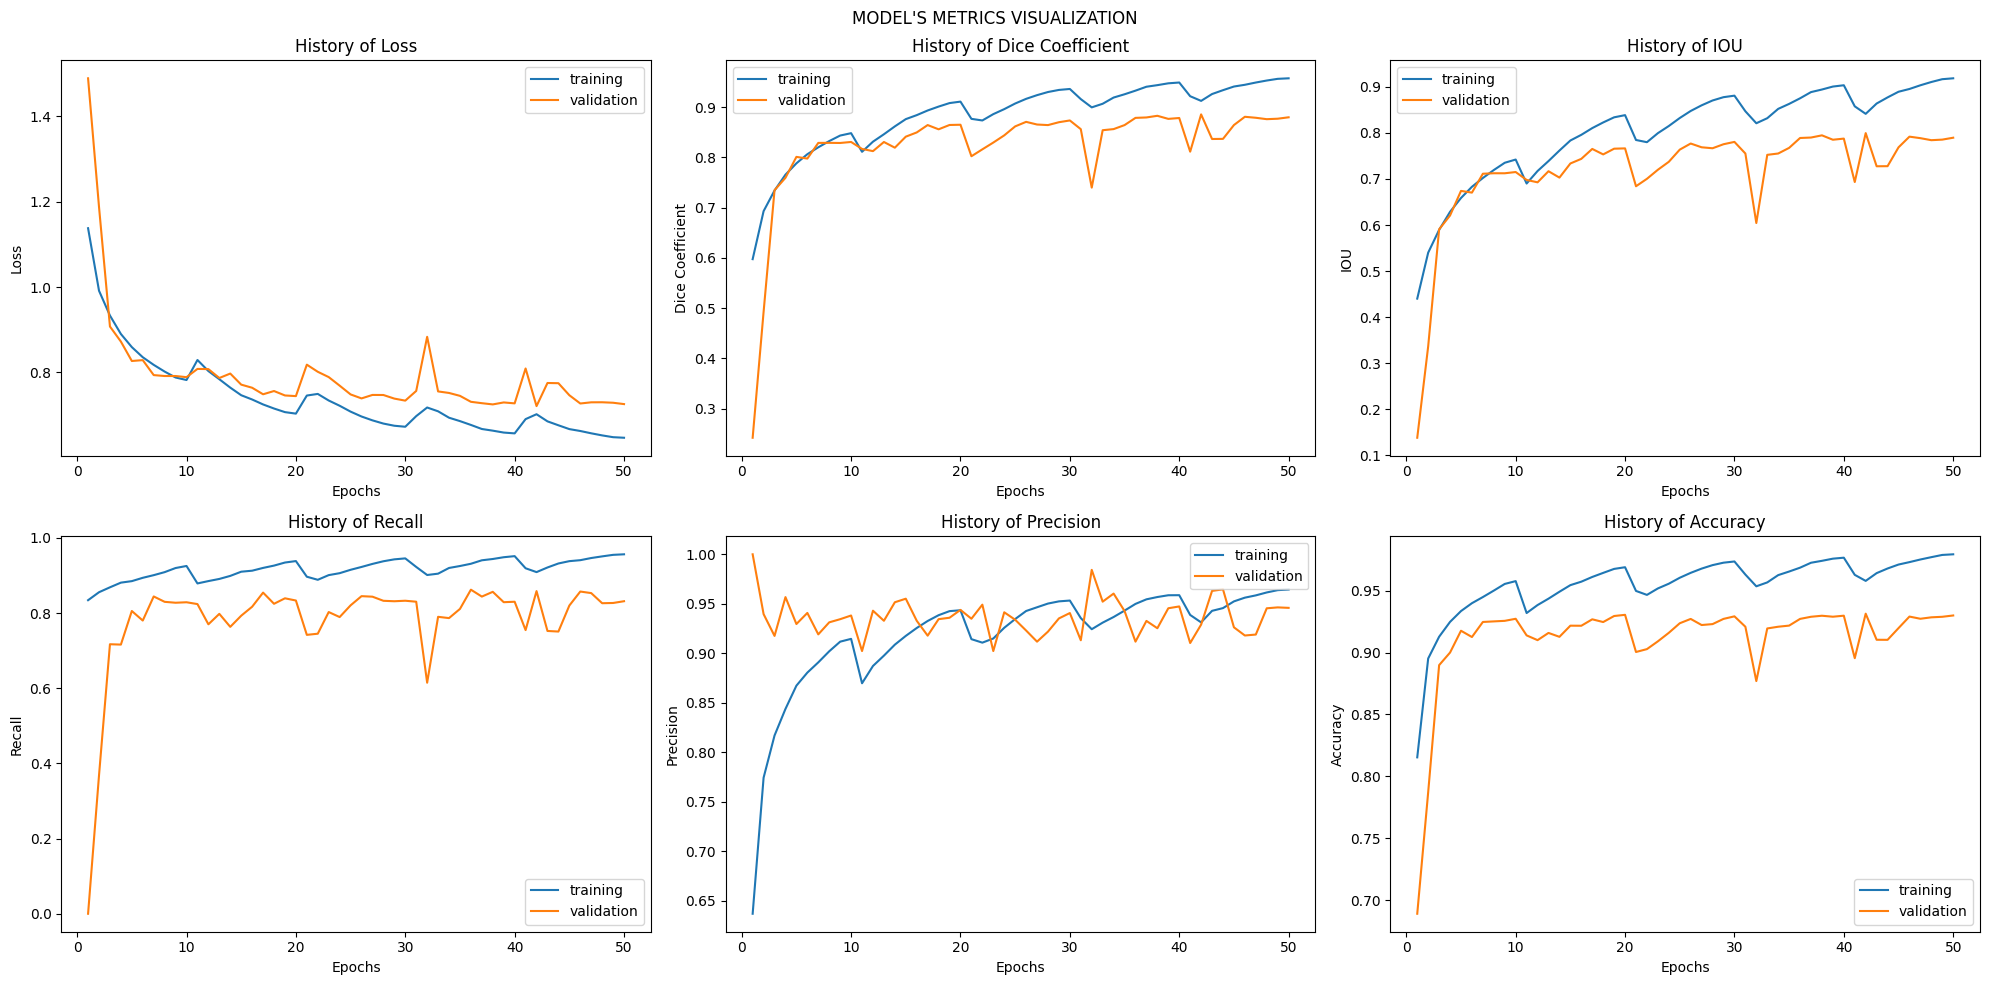

In [10]:
def Train_Val_Plot(loss, val_loss, dice_score, val_dice_score, iou, val_iou, recall, val_recall, precision, val_precision, accuracy, val_accuracy):
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle("MODEL'S METRICS VISUALIZATION")

    # Loss plot
    axs[0, 0].plot(range(1, len(loss) + 1), loss)
    axs[0, 0].plot(range(1, len(val_loss) + 1), val_loss)
    axs[0, 0].set_title('History of Loss')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend(['training', 'validation'])

    # Dice Coefficient plot
    axs[0, 1].plot(range(1, len(dice_score) + 1), dice_score)
    axs[0, 1].plot(range(1, len(val_dice_score) + 1), val_dice_score)
    axs[0, 1].set_title('History of Dice Coefficient')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Dice Coefficient')
    axs[0, 1].legend(['training', 'validation'])

    # Mean IOU plot
    axs[0, 2].plot(range(1, len(iou) + 1), iou)
    axs[0, 2].plot(range(1, len(val_iou) + 1), val_iou)
    axs[0, 2].set_title('History of IOU')
    axs[0, 2].set_xlabel('Epochs')
    axs[0, 2].set_ylabel('IOU')
    axs[0, 2].legend(['training', 'validation'])

    # Recall plot
    axs[1, 0].plot(range(1, len(recall) + 1), recall)
    axs[1, 0].plot(range(1, len(val_recall) + 1), val_recall)
    axs[1, 0].set_title('History of Recall')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Recall')
    axs[1, 0].legend(['training', 'validation'])

    # Precision plot
    axs[1, 1].plot(range(1, len(precision) + 1), precision)
    axs[1, 1].plot(range(1, len(val_precision) + 1), val_precision)
    axs[1, 1].set_title('History of Precision')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Precision')
    axs[1, 1].legend(['training', 'validation'])

    # Accuracy plot
    axs[1, 2].plot(range(1, len(accuracy) + 1), accuracy)
    axs[1, 2].plot(range(1, len(val_accuracy) + 1), val_accuracy)
    axs[1, 2].set_title('History of Accuracy')
    axs[1, 2].set_xlabel('Epochs')
    axs[1, 2].set_ylabel('Accuracy')
    axs[1, 2].legend(['training', 'validation'])

    plt.tight_layout()
    plt.show()

Train_Val_Plot(
    history.history['loss'], history.history['val_loss'],
    history.history['dice_score'], history.history['val_dice_score'],
    history.history['iou'], history.history['val_iou'],
    history.history['recall'], history.history['val_recall'],
    history.history['precision'], history.history['val_precision'],
    history.history['accuracy'], history.history['val_accuracy']
)

In [11]:
model.load_weights("/kaggle/working/snapshot_model_1.h5")
model.evaluate(test_dataset, verbose = 1)

95/95 ━━━━━━━━━━━━━━━━━━━━ 46s 486ms/step - accuracy: 0.9422 - dice_score: 0.8397 - iou: 0.7294 - loss: 0.7858 - precision: 0.9146 - recall: 0.8775


W0000 00:00:1718270525.531421     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.8000093102455139,
 0.9372075200080872,
 0.8292670249938965,
 0.8652843236923218,
 0.9106876850128174,
 0.7144855856895447]

In [12]:
model.load_weights("/kaggle/working/snapshot_model_2.h5")
model.evaluate(test_dataset, verbose = 1)

95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.9426 - dice_score: 0.8703 - iou: 0.7765 - loss: 0.7459 - precision: 0.9101 - recall: 0.8795


[0.7549697756767273,
 0.9390920400619507,
 0.8636773228645325,
 0.8647631406784058,
 0.9148266315460205,
 0.7664052844047546]

In [13]:
model.load_weights("/kaggle/working/snapshot_model_3.h5")
model.evaluate(test_dataset, verbose = 1)

95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.9441 - dice_score: 0.8849 - iou: 0.7996 - loss: 0.7276 - precision: 0.9148 - recall: 0.8809


[0.7367774248123169,
 0.9406949281692505,
 0.8780320882797241,
 0.8656639456748962,
 0.9192256927490234,
 0.7890662550926208]

In [14]:
model.load_weights("/kaggle/working/snapshot_model_4.h5")
model.evaluate(test_dataset, verbose = 1)

95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.9453 - dice_score: 0.8918 - iou: 0.8112 - loss: 0.7187 - precision: 0.9221 - recall: 0.8793


[0.7296700477600098,
 0.9413600564002991,
 0.8836725950241089,
 0.866407036781311,
 0.92201828956604,
 0.7985966801643372]

In [15]:
model.load_weights("/kaggle/working/snapshot_model_5.h5")
model.evaluate(test_dataset, verbose = 1)

95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.9436 - dice_score: 0.8910 - iou: 0.8100 - loss: 0.7196 - precision: 0.9229 - recall: 0.8735


[0.7263192534446716,
 0.9413222670555115,
 0.8865272402763367,
 0.8636300563812256,
 0.9253947734832764,
 0.8024158477783203]